In [74]:
import pandas as pd

In [75]:
df = pd.read_csv("data/synthetic_grocery_dataset.csv")

In [76]:
df

,Item_ID,Item_Name,Item_Description,Price,Weight (g),Category
0,1,Zucchini,Premium zucchini hand-picked.,15.46,2483,Vegetables
1,2,Muffin,Premium muffin no added sugar.,13.04,2196,Bakery
2,3,Carrot,Organic carrot no added sugar.,5.40,208,Vegetables
3,4,Granola Bar,Imported granola bar hand-picked.,11.04,2328,Snacks
4,5,Orange,Delicious orange packed with nutrients.,3.75,664,Fruits
...,...,...,...,...,...,...
495,496,Garlic,Premium garlic from local farms.,11.77,2599,Vegetables
496,497,Frozen Berries,Delicious frozen berries from local farms.,2.12,2622,Frozen
497,498,Frozen Pizza,Low-fat frozen pizza with natural ingredients.,3.22,2043,Frozen
498,499,Banana,Gluten-free banana no added sugar.,13.46,1920,Fruits


Keep only unique grocery items.

In [77]:
df = df.drop_duplicates(keep="first", subset=["Item_Name"])

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

Visualize the distribution of grocery items by category and check class balance.

C:\Users\Manuel\AppData\Local\Temp\ipykernel_38568\1216101316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Category", data=df, palette="Set2")


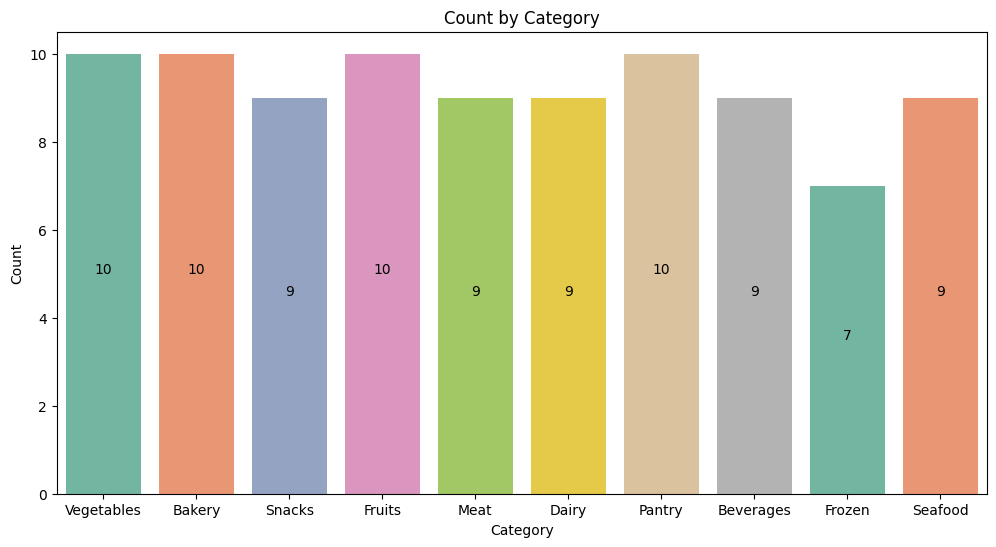

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.countplot(x="Category", data=df, palette="Set2")
ax.set_title("Count by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Count")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height / 2, '{:1.0f}'.format(height), ha="center")

### Category segments inspection
Just as a check, I thought about using a sentence transformer to output embeddings for grocery items so that I could visualize their grouping. For this specifically I will:
1. Convert item names to embeddings.
2. Reduce the number of dimensions per embedding to 2.
3. Scatter plot the points in 2D with unique color per category.

In [80]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
item_embeddings = model.encode(df["Item_Name"].tolist())

In [81]:
item_embeddings.shape

(92, 384)

In [82]:
# Reducing dimensionality using t-SNE
from sklearn.manifold import TSNE
item_embeddings_2d = TSNE(n_components=2).fit_transform(item_embeddings)

In [83]:
df["Item_Name_Embedding_2D"] = list(item_embeddings_2d)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_38568\2721918288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Item_Name_Embedding_2D"] = list(item_embeddings_2d)


In [84]:
import numpy as np

In [85]:
df["Item_Name_Embedding_2D"] = df["Item_Name_Embedding_2D"].apply(lambda x: np.array(x))

C:\Users\Manuel\AppData\Local\Temp\ipykernel_38568\1925325705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Item_Name_Embedding_2D"] = df["Item_Name_Embedding_2D"].apply(lambda x: np.array(x))


In [86]:
df["Item_Name_Embedding_2D"].apply(lambda x: np.array(x)).sum()

array([101.87411 , -52.283382], dtype=float32)

In [87]:
df_centroids = df.groupby("Category")["Item_Name_Embedding_2D"].apply(lambda x: np.mean(x, axis=0))

In [88]:
import hashlib
def map_string_to_color(string: str) -> str:
    return "#" + hashlib.md5(string.encode("utf-8")).hexdigest()[-6:]

C:\Users\Manuel\AppData\Local\Temp\ipykernel_38568\520024804.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(df_centroids[idx][0], df_centroids[idx][1], label, ha="center")


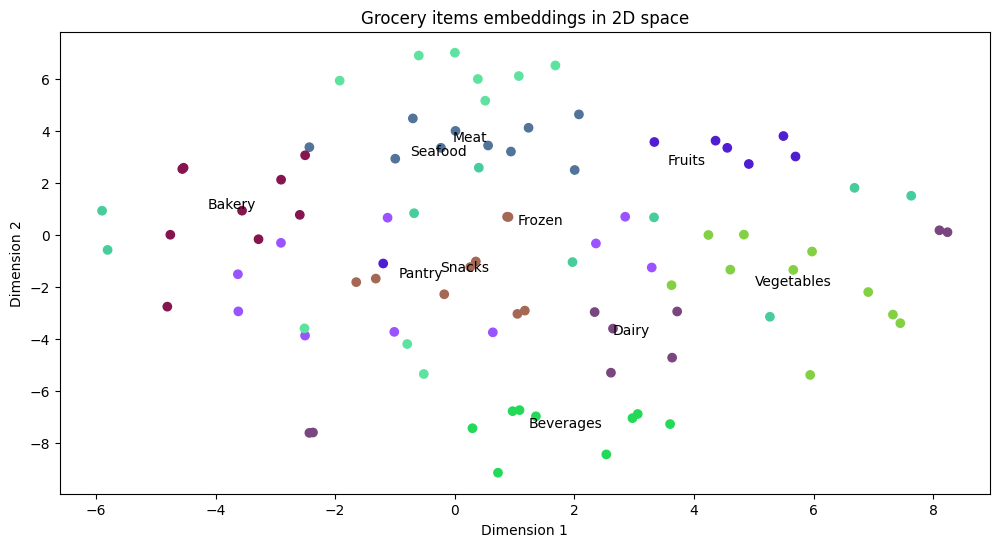

In [89]:
# Scatter plot of embeddings
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], c=df["Category"].apply(map_string_to_color))
ax.set_title("Grocery items embeddings in 2D space")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

for idx, label in enumerate(df["Category"].unique()):
    ax.text(df_centroids[idx][0], df_centroids[idx][1], label, ha="center")

A rather decent grouping of the related items can be seen. Will proceed with a trial for fine-tuning a lightweight autoencoder for classification (e.g., DistilBERT).

### DistilBERT fine-tuning for groceries classification

In [90]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["labels"] = le.fit_transform(df["Category"])
num_labels = len(le.classes_)
print(f"Number of labels: {num_labels}")

Number of labels: 10


C:\Users\Manuel\AppData\Local\Temp\ipykernel_38568\1349818050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"] = le.fit_transform(df["Category"])


In [91]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset

# Load the tokenzier needed by DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Load the dataset
dataset = Dataset.from_pandas(df[["Item_Name", "labels"]])

In [92]:
def tokenize(example):
    encoding = tokenizer(
        example["Item_Name"],
        padding="max_length",
        truncation=True,
        max_length=64
    )
    encoding["labels"] = example["labels"]
    return encoding


In [93]:
tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

Map: 100%|██████████| 92/92 [00:00<00:00, 8366.24 examples/s]


In [94]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Item_Name', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 73
    })
    test: Dataset({
        features: ['Item_Name', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 19
    })
})

In [95]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

In [97]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

In [98]:
import mlflow
from transformers import TrainerCallback

class MLFlowLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            for k, v in logs.items():
                mlflow.log_metric(k, v, step=state.global_step)

In [ ]:
import torch
torch.__version__
print(torch.cuda.is_available())

True


In [100]:
import mlflow.transformers
from transformers import Trainer

mlflow.set_tracking_uri("http://localhost:5000")
with mlflow.start_run(run_name="distilbert-grocery-classification"):

    # Log params
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("epochs", training_args.num_train_epochs)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
    mlflow.log_param("weight_decay", training_args.weight_decay)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[MLFlowLoggingCallback()]
    )

    trainer.train()

    save_path = "groceries-distilbert-mlflow"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    mlflow.transformers.log_model(
        transformers_model={"model": model, "tokenizer": tokenizer},
        artifact_path="model",
        task="text-classification"
    )

C:\Users\Manuel\AppData\Local\Temp\ipykernel_38568\4187455313.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.301832,0.210526,0.096241
2,2.278200,2.272671,0.210526,0.108453
3,2.278200,2.212655,0.315789,0.215205
4,2.106500,2.187974,0.315789,0.216291
5,2.106500,2.171230,0.315789,0.214536


2025/06/29 17:14:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Device set to use cuda:0
2025/06/29 17:14:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/29 17:14:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.1+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.22.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/29 17:14:32 WARNING mlflow.utils.environment: On Windows, timeout is not supported for model r

🏃 View run distilbert-grocery-classification at: http://localhost:5000/#/experiments/0/runs/a465bcca458047b197963a74d1f94315
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [ ]:
model_uri = "runs:/9d2521c39c3349eab434e36db8cb9a82/model"
loaded_pipeline = mlflow.transformers.load_model(model_uri)

In [161]:
# Check an arbitrary item category
test_items = ["apricot", "apio", "apple", "peach", "trout"]
for item in test_items:
    pred = loaded_pipeline.predict(item)
    label = le.inverse_transform([int(pred[0]["label"].split("_")[1])])[0]
    print(f"Item: {item} \t Predicted label: {label} [{pred[0]['score']*100:.2f}%] \t Is in original dataset?: {df['Item_Name'].str.lower().str.fullmatch(item).sum() > 0}")

Item: apricot 	 Predicted label: Fruits [56.70%] 	 Is in original dataset?: False
Item: apio 	 Predicted label: Vegetables [81.89%] 	 Is in original dataset?: False
Item: apple 	 Predicted label: Fruits [98.82%] 	 Is in original dataset?: True
Item: peach 	 Predicted label: Fruits [98.65%] 	 Is in original dataset?: False
Item: trout 	 Predicted label: Seafood [98.24%] 	 Is in original dataset?: False
